The code in this notebook processes wikipedia page view data from January 2008 through August 2019.

Data was gathered from the <a href="https://wikimedia.org/api/rest_v1/">Wikimedia REST API</a>,
Wikimedia Foundation, 2018. CC-BY-SA 3.0

Through the two APIs provided by Wikimedia (<a href="https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end">one for legacy data</a>, <a href="https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end">one for the updated data definitions</a>), five calls are made to retrieve the relevant data. The responses are stored in respective json files, each named in the following format:

apiname_accesstype_firstmonth-lastmonth.json
* api values: pagecounts, pageviews
* page count accesstype values: desktop-site, mobile-site
* page view accesstype values: desktop, mobile-app, mobile-web

Next, each json file will be pulled into a Pandas dataframe. From there, they will be merged into a single dataframe by matching timestamps and stored in a csv file, which will be used for analysis. The records are aggregated by month and year.
For this step, it should be noted that although the new pageview definitions discern between mobile app page views and mobile browser page views, they are summed into a single value representing all mobile traffic for the purposes of this analysis. Entries with 0 page views/counts indicate no data being available for that month under that access method.

In the final plot, all the page view counts are scaled down by factor of 1,000,000. Also, after the page view definitions changed in May 2015, through July 2016, both APIs were in effect. Consequently, there is some overlap in data. This is indicated in the plot by a shift from dotted lines to solid lines, solid lines representing the new definitions. The new definitions differentiated user views from crawler views. The solid lines in the plot reflect the crawler view counts being ignored.

In [1]:
from datetime import datetime
from numpy import NaN
from matplotlib.dates import DateFormatter

import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
headers = {
    'User-Agent': 'https://github.com/adrianmt18',
    'From': 'mr_tullock@yahoo.com'
}

def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

# Generate and dump pagecounts json file
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
def dump_pagecounts(start='2008010100', end='2016080100'):
    api = 'pagecounts'
    # Available values for 'access-site' parameter
    list_access_site = list(('desktop-site','mobile-site'))
    end_point = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
    
    for ac_site in list_access_site:
        params = {"project" : "en.wikipedia.org",
                      "access-site" : ac_site,
                      "granularity" : "monthly",
                      "start" : start,
                    # for end, use 1st day of month following final month of data
                      "end" : end
                 }
        
        f_name = api + "-" + ac_site + "-" + start[0:-4] + "-" + end[0:-4] + ".json"
        json.dump(api_call(end_point, params), open(f_name,"w"))
        
    return

# Generate and dump pageviews json file
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
def dump_pageviews(start='2015070100', end='2019090100'):
    api = 'pageviews'
    # Available values for 'access' parameter
    list_access = list(('desktop','mobile-app','mobile-web'))
    end_point = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
    
    for acs in list_access:
        params = {"project" : "en.wikipedia.org",
                      "access" : acs,
                      "agent" : "user",
                      "granularity" : "monthly",
                      "start" : start,
                    # for end, use 1st day of month following final month of data
                      "end" : end
                 }
        
        f_name = api + "-" + acs + "-" + start[0:-4] + "-" + end[0:-4] + ".json"
        json.dump(api_call(end_point, params), open(f_name,"w"))
    
    return

# generate csv file from json data
def csv_gen():
    # retrieve data from json files
    df_pagecount_desktop = pd.DataFrame(json.load(open('pagecounts-desktop-site-200801-201608.json', 'r'))['items'], columns=['access-site','count','timestamp']).rename(columns = {"count" : "pagecount_desktop_views", "access-site" : "access"})
    df_pagecount_mobile = pd.DataFrame(json.load(open('pagecounts-mobile-site-200801-201608.json', 'r'))['items'], columns=['access-site','count','timestamp']).rename(columns = {"count" : "pagecount_mobile_views", "access-site" : "access"})
    df_pageview_desktop = pd.DataFrame(json.load(open('pageviews-desktop-201507-201909.json', 'r'))['items'], columns=['access', 'timestamp','views']).rename(columns = {"views" : "pageview_desktop_views"})
    df_pageview_mobile = pd.DataFrame(json.load(open('pageviews-mobile-web-201507-201909.json', 'r'))['items'], columns=['access', 'timestamp','views']).rename(columns = {"views" : "pageview_mobile_views"})
    df_pageview_app = pd.DataFrame(json.load(open('pageviews-mobile-app-201507-201909.json', 'r'))['items'], columns=['access', 'timestamp','views']).rename(columns = {"views" : "pageview_mobile_views"})
    # Combine page views for mobile-app and mobile-web
    df_pageview_mobile['pageview_mobile_views'] += df_pageview_app['pageview_mobile_views']
    
    # add month and year columns
    df_pagecount_desktop['year'] = df_pagecount_desktop['timestamp']
    df_pagecount_desktop['month'] = df_pagecount_desktop['timestamp']
    for i in range(0, len(df_pagecount_desktop)):
        df_pagecount_desktop['year'][i] = df_pagecount_desktop['timestamp'][i][0:4]
        df_pagecount_desktop['month'][i] = df_pagecount_desktop['timestamp'][i][4:6]

    df_pagecount_mobile['year'] = df_pagecount_mobile['timestamp']
    df_pagecount_mobile['month'] = df_pagecount_mobile['timestamp']
    for i in range(0, len(df_pagecount_mobile)):
        df_pagecount_mobile['year'][i] = df_pagecount_mobile['timestamp'][i][0:4]
        df_pagecount_mobile['month'][i] = df_pagecount_mobile['timestamp'][i][4:6]

    df_pageview_desktop['year'] = df_pageview_desktop['timestamp']
    df_pageview_desktop['month'] = df_pageview_desktop['timestamp']
    for i in range(0, len(df_pageview_desktop)):
        df_pageview_desktop['year'][i] = df_pageview_desktop['timestamp'][i][0:4]
        df_pageview_desktop['month'][i] = df_pageview_desktop['timestamp'][i][4:6]

    df_pageview_mobile['year'] = df_pageview_mobile['timestamp']
    df_pageview_mobile['month'] = df_pageview_mobile['timestamp']
    for i in range(0, len(df_pageview_mobile)):
        df_pageview_mobile['year'][i] = df_pageview_mobile['timestamp'][i][0:4]
        df_pageview_mobile['month'][i] = df_pageview_mobile['timestamp'][i][4:6]
    
    # merge DataFrames
    df_desktop = df_pagecount_desktop.merge(df_pageview_desktop, how='outer', on=['timestamp','year', 'month'])
    df_mobile = df_pagecount_mobile.merge(df_pageview_mobile, how='outer', on=['timestamp','year', 'month'])
    df_all_data = df_desktop.merge(df_mobile, how='outer', on=['timestamp','year', 'month']).fillna(0)
    
    # create wiki traffic DataFrame
    cols = ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
        'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']
    df_wiki_traffic = pd.DataFrame(columns=cols)
    
    df_wiki_traffic['year'] = df_all_data['year']
    df_wiki_traffic['month'] = df_all_data['month']
    df_wiki_traffic['pagecount_all_views'] = df_all_data['pagecount_desktop_views'] + df_all_data['pagecount_mobile_views']
    df_wiki_traffic['pagecount_desktop_views'] = df_all_data['pagecount_desktop_views']
    df_wiki_traffic['pagecount_mobile_views'] = df_all_data['pagecount_mobile_views']
    df_wiki_traffic['pageview_all_views'] = df_all_data['pageview_desktop_views'] + df_all_data['pageview_mobile_views']
    df_wiki_traffic['pageview_desktop_views'] = df_all_data['pageview_desktop_views']
    df_wiki_traffic['pageview_mobile_views'] = df_all_data['pageview_mobile_views']
    
    # Create csv file
    df_wiki_traffic.to_csv('en-wikipedia_traffic_200712-201809.csv', index=False)
    
    return

In [3]:
# Data processing step. This will take some time.
dump_pagecounts()
dump_pageviews()
csv_gen()
df = pd.read_csv('en-wikipedia_traffic_200712-201809.csv', sep=',')

C:\Users\Ace\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ace\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ace\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ace\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

[Text(0, 0.5, 'Page Views'),
 Text(0.5, 1.0, 'Page Views on English Wikipedia (x 1,000,000)')]

Text(0.5, 0, 'May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.')

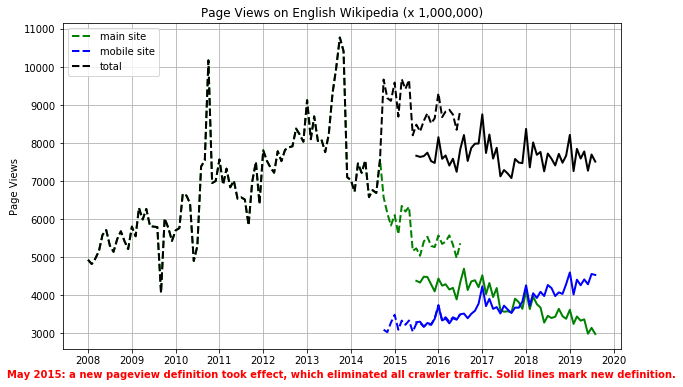

In [4]:
# Format dates for plotting
dates = []
for y,m in zip(df['year'], df['month']):
    date = datetime.strptime(str(y)+str(m),"%Y%m")
    dates.append(date)

# Generate time series plot
fig, ax = plt.subplots(figsize=(10,6))

main_legacy = df['pagecount_desktop_views'].replace(0,NaN)/1e6
main_modern = df['pageview_desktop_views'].replace(0,NaN)/1e6
ax.plot(dates, main_legacy,'g--', linewidth=2, label='main site')
ax.plot(dates, main_modern,'g-', linewidth=2)

mobile_legacy = df['pagecount_mobile_views'].replace(0,NaN)/1e6
mobile_modern = df['pageview_mobile_views'].replace(0,NaN)/1e6
ax.plot(dates, mobile_legacy,'b--', linewidth=2, label='mobile site')
ax.plot(dates, mobile_modern,'b-', linewidth=2)

total_legacy = df['pagecount_all_views'].replace(0,NaN)/1e6
total_modern = df['pageview_all_views'].replace(0,NaN)/1e6
ax.plot(dates, total_legacy,'k--', linewidth=2, label='total')
ax.plot(dates, total_modern,'k-', linewidth=2)

ax.set(ylabel="Page Views", title="Page Views on English Wikipedia (x 1,000,000)")
ax.set_xlabel('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.',
              fontsize='medium', fontweight='bold', c='r')
ax.grid(True)
ax.legend(loc='upper left')

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.YearLocator())

In [6]:
# Export the chart as a JPEG file
fig.savefig('pageviews.jpg')

In [8]:
df[80:130]

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
80,2014,9,7.564601e+09,7.564601e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
81,2014,10,9.669080e+09,6.577533e+09,3.091547e+09,0.000000e+00,0.000000e+00,0.000000e+00
82,2014,11,9.181027e+09,6.153538e+09,3.027490e+09,0.000000e+00,0.000000e+00,0.000000e+00
83,2014,12,9.109282e+09,5.830332e+09,3.278950e+09,0.000000e+00,0.000000e+00,0.000000e+00
84,2015,1,9.589069e+09,6.103767e+09,3.485302e+09,0.000000e+00,0.000000e+00,0.000000e+00
85,2015,2,8.694245e+09,5.602710e+09,3.091534e+09,0.000000e+00,0.000000e+00,0.000000e+00
86,2015,3,9.677435e+09,6.346603e+09,3.330833e+09,0.000000e+00,0.000000e+00,0.000000e+00
87,2015,4,9.421036e+09,6.198946e+09,3.222090e+09,0.000000e+00,0.000000e+00,0.000000e+00
88,2015,5,9.657871e+09,6.323802e+09,3.334069e+09,0.000000e+00,0.000000e+00,0.000000e+00
89,2015,6,8.203576e+09,5.165414e+09,3.038162e+09,0.000000e+00,0.000000e+00,0.000000e+00
